# Guiding Diffusion Models: Classifier Guidance on MNIST

In this notebook, we will implement Classifier Guidance to steer the generation of a pre-trained DDPM model towards specific MNIST digits. We will:

1. Load the pre-trained DDPM model (trained on MNIST).
2. Implement a simple classifier for MNIST digits that can handle noisy inputs.
3. Implement the classifier guidance sampling loop.
4. Generate images of specific digits using guidance.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from tqdm.auto import tqdm

# Add the src directory to Python path
sys.path.append(os.path.abspath('./'))

# Import our modules
from src.model import SimpleUnet
from src.data import get_mnist_dataset
from src.scheduler import linear_beta_schedule
from src.diffusion import DiffusionProcess, DDIM # Ensure DDIM is imported
from src.utils import plot_images

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Get the dataset
train_dataset, test_dataset = get_mnist_dataset(root='./data')

Using device: mps


## Load the Pre-trained DDPM Model

We'll use the same pre-trained U-Net model from the previous notebooks.

In [2]:
# Load the pre-trained DDPM model
ddpm_model = SimpleUnet(in_channels=1).to(device) # Ensure out_channels=1 for noise prediction
model_path = os.path.join('models', 'diffusion_model.pth')

try:
    ddpm_model.load_state_dict(torch.load(model_path, map_location=device))
    ddpm_model.eval()
    print("Pre-trained DDPM model loaded successfully!")
except Exception as e:
    print(f"Error loading DDPM model: {e}")

# Initialize variance schedule and DiffusionProcess
timesteps = 1000
beta_schedule_tensor = linear_beta_schedule(timesteps).to(device)
diffusion_process = DiffusionProcess(beta_schedule_tensor)

Pre-trained DDPM model loaded successfully!


## Implement a Classifier for Noisy MNIST Digits

For classifier guidance, we need a classifier $p_{\phi}(y|x_t)$ that can predict the digit $y$ given a noisy image $x_t$. We'll train a simple CNN classifier on noisy MNIST images.

In [3]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # MNIST images are 32x32. After two 2x2 max pools, size is 32 -> 16 -> 8.
        # So, 64 channels * 8 * 8 features.
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10) # 10 classes for MNIST

    def forward(self, x, t=None): # t is not used by this simple classifier but often present in guided diffusion contexts
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Logits
        return x

classifier = MNISTClassifier().to(device)
classifier_path = os.path.join('models', 'mnist_classifier.pth')

# We'll need to train this classifier.
# For now, let's define the training loop.
# If a pre-trained one exists, we can load it.

### Train the MNIST Classifier

The classifier needs to be robust to noisy inputs. We will train it by adding varying amounts of noise to the MNIST images during its training.

In [4]:
def train_classifier(classifier, diffusion_process, dataloader, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Ensure the model is in training mode
    classifier.train()

    print("Starting classifier training...")
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            images, labels = images.to(device), labels.to(device)
            
            # Add random noise to images
            # Sample a random timestep for each image in the batch
            t = torch.randint(0, diffusion_process.timesteps, (images.shape[0],), device=device).long()
            # Use corrupt_image instead of forward_diffusion
            noisy_images, _ = diffusion_process.corrupt_image(images, t) 
            
            optimizer.zero_grad()
            outputs = classifier(noisy_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

    print("Classifier training finished.")
    # Save the trained classifier
    torch.save(classifier.state_dict(), classifier_path)
    print(f"Classifier saved to {classifier_path}")

# Check if a pre-trained classifier exists
if os.path.exists(classifier_path):
    print(f"Loading pre-trained classifier from {classifier_path}")
    classifier.load_state_dict(torch.load(classifier_path, map_location=device))
    classifier.eval() # Set to evaluation mode
else:
    print("No pre-trained classifier found. Training a new one...")
    # Create a DataLoader for training the classifier
    # Using a larger batch size for classifier training is common
    classifier_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    train_classifier(classifier, diffusion_process, classifier_train_loader, epochs=30) # Train for more epochs if needed
    classifier.eval() # Set to evaluation mode after training

Loading pre-trained classifier from models/mnist_classifier.pth


## Implement Classifier Guidance Sampling Loop

Now we'll implement the sampling loop that incorporates classifier guidance.
The core idea is to adjust the noise prediction $\epsilon_{\theta}(x_t, t)$ using the gradient of the classifier's log-likelihood $\nabla_{x_t} \log p_{\phi}(y|x_t)$.

The modified noise prediction is:
$$ \epsilon'_{\theta}(x_t, t, y) = \epsilon_{\theta}(x_t, t) - w \sqrt{1-\bar{\alpha}_t} \nabla_{x_t} \log p_{\phi}(y|x_t) $$
where $w$ is the guidance scale.

In [5]:
def classifier_guided_sample(
    ddpm_model, # The U-Net (noise predictor)
    diffusion_process, # The DiffusionProcess instance
    classifier, # The trained MNIST classifier
    n_samples,
    img_shape, # e.g., (1, 32, 32)
    device,
    target_class, # The class we want to generate (0-9)
    guidance_scale # Strength of the guidance (w)
    ):

    ddpm_model.eval()
    classifier.eval()

    # Start from pure noise
    img = torch.randn((n_samples, *img_shape), device=device)
    
    history = [] # To store intermediate images for visualization

    for t_idx in tqdm(range(diffusion_process.timesteps - 1, -1, -1), desc="Classifier Guided Sampling"):
        t_tensor = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)
        
        # We need gradients for the input to the classifier
        img_for_classifier = img.detach().requires_grad_(True)
        
        # 1. Get classifier's log probability for the target class
        logits = classifier(img_for_classifier) # No specific t for this simple classifier
        log_probs = F.log_softmax(logits, dim=-1)
        selected_log_probs = log_probs[:, target_class] # Log p_phi(y|x_t) for the target_class
        
        # 2. Compute the gradient: nabla_{x_t} log p_phi(y|x_t)
        # Summing selected_log_probs before backward to get one gradient per image in batch
        gradient = torch.autograd.grad(selected_log_probs.sum(), img_for_classifier)[0]
        
        # 3. Get unconditional noise prediction from DDPM model
        with torch.no_grad():
            noise_pred_uncond = ddpm_model(img, t_tensor) # epsilon_theta(x_t, t)
        
        # 4. Calculate the adjustment term for guidance
        # The sqrt(1-alphabar_t) term from the formula
        # For DDPM, this is related to 1.0 / diffusion_process.sqrt_recip_alphas_t[t_idx]
        # Or more directly, if we use the score formulation, it's often simplified.
        # The sign and scaling factor can vary in implementations.
        # The original paper uses: eps_hat = eps_theta - sqrt(1-alpha_bar_t) * s * grad(log p(y|xt))
        
        # Adjusted noise prediction
        # noise_pred_guided = noise_pred_uncond - guidance_scale * sqrt_one_minus_alphas_cumprod_t * gradient
        # Simpler version often used (absorbs sqrt term into guidance_scale or assumes score-based adjustment):
        noise_pred_guided = noise_pred_uncond - guidance_scale * gradient # Common simplification

        # 5. Perform the DDPM sampling step with the guided noise
        img = diffusion_process.p_sample(img, t_idx, noise_pred_guided) # Pass guided noise
        
        if t_idx % 100 == 0 or t_idx < 10: # Store some images for visualization
            history.append(img.detach().cpu())
            
    ddpm_model.train() # Set back to train mode if it was changed
    return img.detach().cpu(), history

## Generate Digits with Classifier Guidance

Let's try generating a few samples of a specific digit using our classifier-guided sampling.

Generating 4 samples of digit '7' with guidance scale 3.0...


Classifier Guided Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

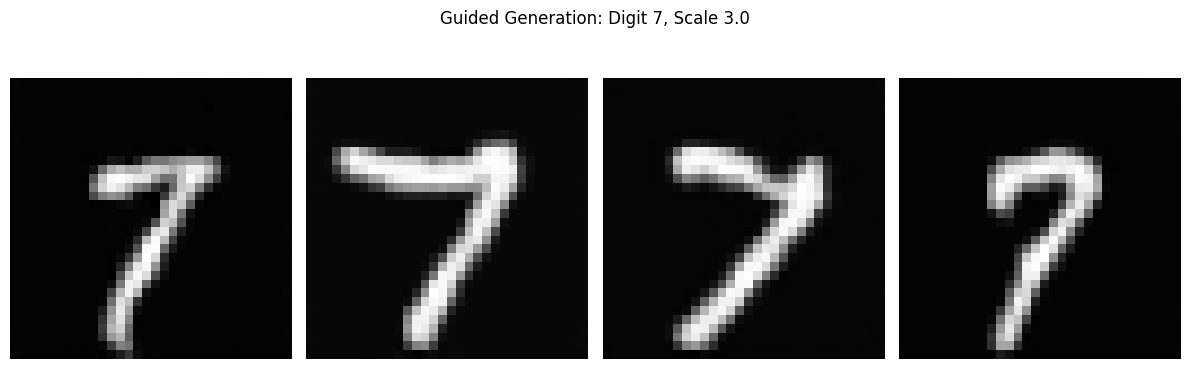

Visualizing generation history for the first sample...


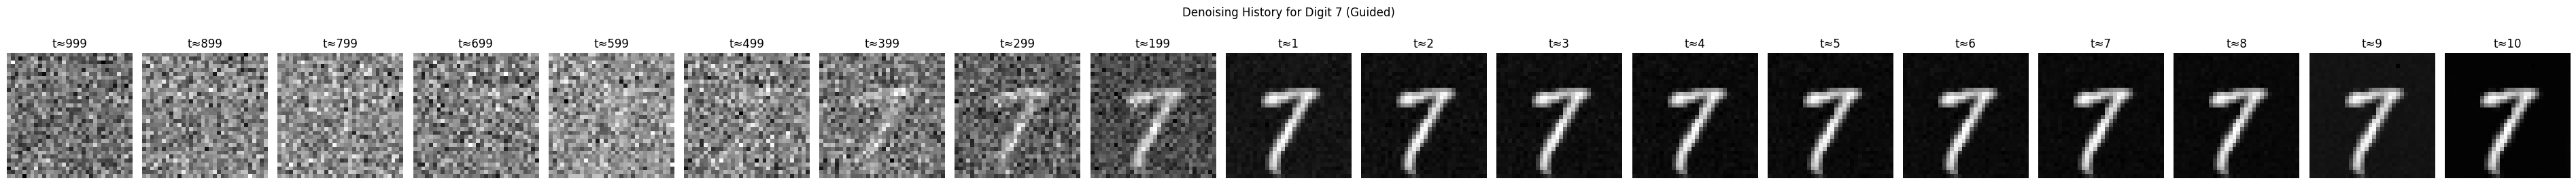

In [11]:
# Parameters for generation
num_samples_to_generate = 4
target_digit = 7  # Let's try to generate the digit '7'
guidance_strength = 3.0 # Experiment with this value (e.g., 0.5, 1.0, 2.0, 5.0)

print(f"Generating {num_samples_to_generate} samples of digit '{target_digit}' with guidance scale {guidance_strength}...")

generated_images, generation_history = classifier_guided_sample(
    ddpm_model=ddpm_model,
    diffusion_process=diffusion_process,
    classifier=classifier,
    n_samples=num_samples_to_generate,
    img_shape=(1, 32, 32), # MNIST image shape (channels, height, width)
    device=device,
    target_class=target_digit,
    guidance_scale=guidance_strength
)

# Plot the final generated images
plot_images(generated_images, title=f"Guided Generation: Digit {target_digit}, Scale {guidance_strength}")

# Optionally, visualize the generation process for one sample
if generation_history:
    print("Visualizing generation history for the first sample...")
    fig, axes = plt.subplots(1, len(generation_history), figsize=(len(generation_history) * 2, 3))
    for i, img_step in enumerate(generation_history):
        ax = axes[i]
        ax.imshow(img_step[0].squeeze(), cmap="gray") # Display first image of the batch
        ax.axis("off")
        # Find the timestep corresponding to this history point (approximate)
        # history is appended every 100 steps or last 10 steps
        # This is a rough mapping back to t for title
        current_t = max(0, diffusion_process.timesteps - 1 - i*100) if i < (len(generation_history)-10) else (10 - (len(generation_history) - 1 - i))
        ax.set_title(f"t≈{current_t}")
    plt.suptitle(f"Denoising History for Digit {target_digit} (Guided)")
    plt.tight_layout()
    plt.show()

## Experiment with Guidance Scale and Target Class

Try changing `target_digit` and `guidance_strength` in the cell above to see how it affects the generated samples.

- A higher `guidance_strength` should make the generated images more clearly resemble the target digit, but too high a value can lead to artifacts or overly "sharp" / unnatural images.
- A lower `guidance_strength` will result in more diversity but less adherence to the target class.
- `guidance_strength = 0` should be equivalent to unconditional sampling.


## Conclusion for Classifier Guidance

In this section, we:
1. Loaded a pre-trained DDPM.
2. Implemented and trained (or loaded) a simple CNN classifier for noisy MNIST digits.
3. Developed a sampling function that uses gradients from this classifier to guide the diffusion model's generation process.
4. Demonstrated how to generate images of specific digits by providing a target class and a guidance scale.

Classifier guidance is a powerful technique but has the overhead of requiring a separate classifier model that needs to be trained (often on noisy data) and run at each sampling step. Next, we might explore Classifier-Free Guidance, which avoids the need for an external classifier.

## Classifier Guidance with DDIM

Now, let's adapt the classifier guidance logic to work with the DDIM sampling process. This will allow us to potentially achieve guided generation with fewer steps.

The core guidance mechanism remains the same: we adjust the predicted noise using the gradient from the classifier. However, the sampling step itself will use the DDIM update rule.

We'll define a new sampling function `classifier_guided_sample_ddim` and experiment with different numbers of DDIM steps (`N_ddim_steps`).

In [12]:
def classifier_guided_sample_ddim(
    ddpm_model,       # The U-Net (noise predictor)
    ddim_process,     # The DDIM instance
    classifier,       # The trained MNIST classifier
    n_samples,
    img_shape,        # e.g., (1, 32, 32)
    device,
    target_class,     # The class we want to generate (0-9)
    guidance_scale,   # Strength of the guidance (w)
    N_ddim_steps,     # Number of DDIM steps to take (e.g., 50, 100)
    eta=0.0           # DDIM eta parameter (0 for deterministic, 1 for DDPM-like)
):
    ddpm_model.eval()
    classifier.eval()

    img = torch.randn((n_samples, *img_shape), device=device)
    history = []

    ddim_timesteps = torch.linspace(ddim_process.timesteps - 1, 0, N_ddim_steps + 1).long().to(device) # N_ddim_steps intervals mean N_ddim_steps+1 points

    for i in tqdm(range(N_ddim_steps), desc="DDIM Classifier Guided Sampling"):
        t_idx = ddim_timesteps[i]
        t_prev_idx = ddim_timesteps[i+1]
        
        t_tensor = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)

        img_for_classifier = img.detach().requires_grad_(True)
        
        logits = classifier(img_for_classifier) 
        log_probs = F.log_softmax(logits, dim=-1)
        selected_log_probs = log_probs[:, target_class]
        
        gradient = torch.autograd.grad(selected_log_probs.sum(), img_for_classifier)[0]
        
        with torch.no_grad():
            noise_pred_uncond = ddpm_model(img, t_tensor)
        
        noise_pred_guided = noise_pred_uncond - guidance_scale * gradient

        # Use the new ddim_step method
        img = ddim_process.ddim_step(
            model_output=noise_pred_guided, 
            timestep=t_idx.item(), # ddim_step expects scalar int
            next_timestep=t_prev_idx.item(), # ddim_step expects scalar int
            sample=img, 
            eta=eta
        )
        
        if N_ddim_steps <= 20 or i % (N_ddim_steps // 10) == 0 or i == N_ddim_steps - 1:
            history.append(img.detach().cpu())
            
    ddpm_model.train()
    return img.detach().cpu(), history

Generating 4 samples of digit '0' with DDIM (100 steps, eta=0.0), guidance scale 5.0...


DDIM Classifier Guided Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

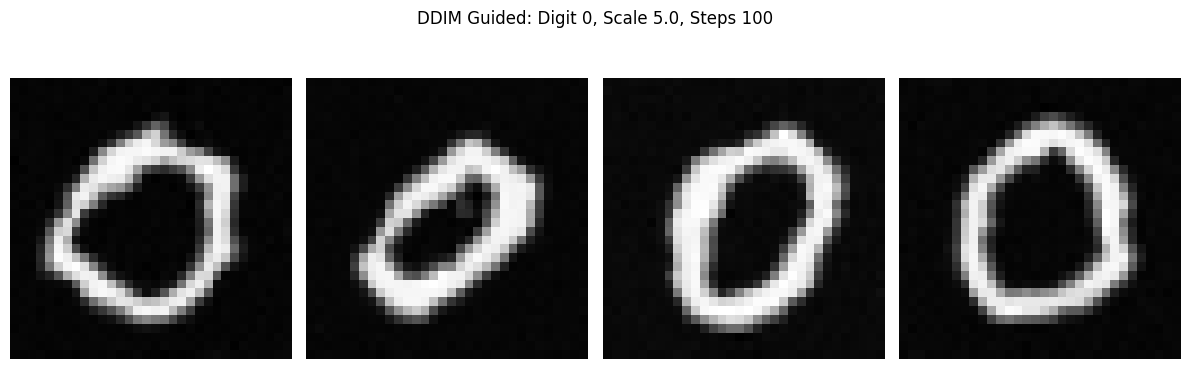

Visualizing DDIM generation history for the first sample...


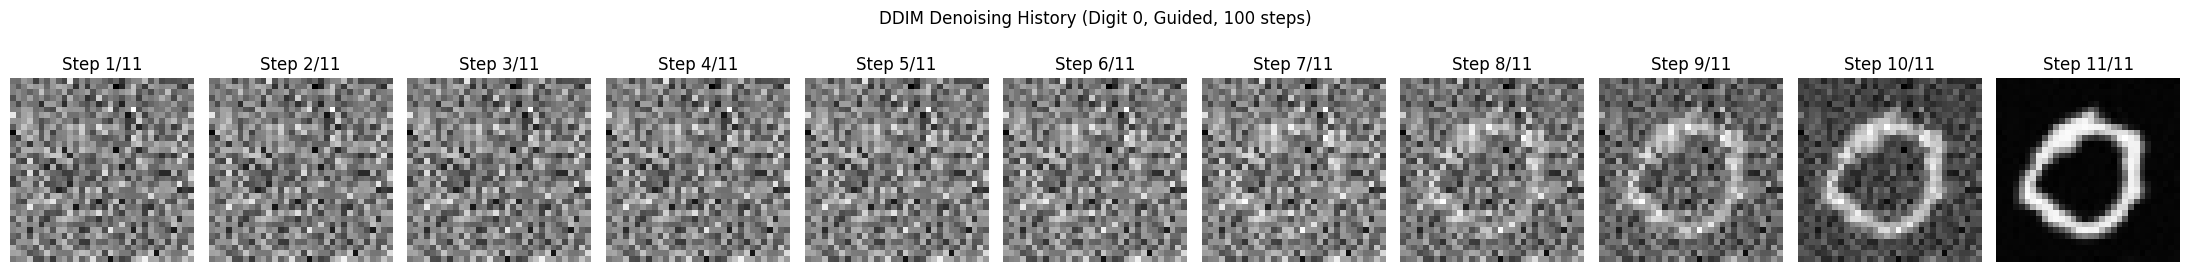

In [15]:
# Parameters for DDIM generation
num_samples_ddim = 4
target_digit_ddim = 0 # Changed to 7 for variety
guidance_strength_ddim = 5.0 
N_ddim_steps = 100 # Number of steps for DDIM sampling
eta_ddim = 0.0 # Deterministic DDIM

print(f"Generating {num_samples_ddim} samples of digit '{target_digit_ddim}' with DDIM ({N_ddim_steps} steps, eta={eta_ddim}), guidance scale {guidance_strength_ddim}...")

# Initialize DDIM process
# Ensure beta_schedule_tensor is defined (it should be from earlier cells)
ddim_process = DDIM(beta_schedule_tensor) 

generated_images_ddim, history_ddim = classifier_guided_sample_ddim(
    ddpm_model=ddpm_model,
    ddim_process=ddim_process,
    classifier=classifier,
    n_samples=num_samples_ddim,
    img_shape=(1, 32, 32),
    device=device,
    target_class=target_digit_ddim,
    guidance_scale=guidance_strength_ddim,
    N_ddim_steps=N_ddim_steps,
    eta=eta_ddim
)

# Plot the final generated images
plot_images(generated_images_ddim, title=f"DDIM Guided: Digit {target_digit_ddim}, Scale {guidance_strength_ddim}, Steps {N_ddim_steps}")

# Optionally, visualize the generation process for one sample
if history_ddim:
    print("Visualizing DDIM generation history for the first sample...")
    fig, axes = plt.subplots(1, len(history_ddim), figsize=(len(history_ddim) * 2, 3))
    for i, img_step in enumerate(history_ddim):
        ax = axes[i]
        ax.imshow(img_step[0].squeeze(), cmap="gray")
        ax.axis("off")
        ax.set_title(f"Step {i+1}/{len(history_ddim)}") # Adjusted title
    plt.suptitle(f"DDIM Denoising History (Digit {target_digit_ddim}, Guided, {N_ddim_steps} steps)")
    plt.tight_layout()
    plt.show()

### Experiment with DDIM Steps and Guidance

Try modifying `N_ddim_steps`, `guidance_strength_ddim`, and `target_digit_ddim` in the cell above.

- How does the quality change with fewer `N_ddim_steps` (e.g., 20, 50, 100)?
- How does `eta_ddim` affect the results (e.g., `eta=0.0` vs `eta=1.0`)?
- Compare the generation speed and quality to the DDPM-based guidance.